# Learning from experts

In [1]:
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt

In [2]:
# number of experts
n = 100
# number of rounds played
T = 10000

## Problem setup

We assume the existance of a set of predetermined answers: *Yes* or *No*.

In [3]:
list_of_correct_answers = random.choice([False, True], T)

Every expert gets a probability with which they give a wrong answer.

In [40]:
probs = np.array([random.random()**(1/2) for _ in range(n)])

def get_expert_answers(true_answer):
    """Generate expert answers based on the true answer and a given probability 
    of lying for each expert."""
    expert_answers = np.empty_like(probs, dtype=bool)
    rnd = random.random(n)
    experts_that_lie = (rnd <= probs)
    expert_answers[experts_that_lie] = np.logical_not(true_answer)
    expert_answers[~experts_that_lie] = true_answer
    
    return expert_answers

## The algorithm

If an expert $i$ is wrong its weight for the next round gets decreased according to the rule:
$$w_{t+1}(i) = w_t(i) (1-\alpha).$$

The next method implements the *randomized and the deterministic* method via the `randomized` flag.

In [32]:
def WMA(n, T, alpha=0.1, randomized=False, random_experts=True):
    """Run the weighted majority algorithm with `n` experts for `T` timesteps"""
    
    # initialize weights
    weights = np.ones(n)
    numof_your_mistakes = 0
    numof_expert_mistakes = np.zeros((n,T+1))
    
    for t in range(T):       
        true_answer = list_of_correct_answers[t]
        if random_experts:
            expert_answers = get_expert_answers(true_answer)
        else:
            expert_answers = get_expert_answers_not_completely_random(true_answer, weights)
            
        your_answer = form_your_answer(expert_answers, weights, randomized)
          
        # check result      
        if your_answer != true_answer:
            numof_your_mistakes += 1
            
        # update weights and expert mistakes
        wrong = expert_answers != true_answer
        numof_expert_mistakes[wrong, t+1] = numof_expert_mistakes[wrong, t]+1
        numof_expert_mistakes[~wrong, t+1] = numof_expert_mistakes[~wrong, t]
        weights[expert_answers != true_answer] *= 1-alpha
                
                
    return numof_your_mistakes, numof_expert_mistakes        

The next function is just part of WMA.

In [6]:
def form_your_answer(expert_answers, weights, randomized):
    """Return your answer in one round of the (randomized) WMA algorithm based 
    on the answers of the experts and the corresponding weights"""
    
    if randomized:
        prob = weights / np.sum(weights)
        your_answer = np.random.choice(expert_answers, size=1, p=prob)        
        return your_answer
    else:          
        weight_yes = weights[expert_answers].sum()
        weight_no = weights.sum() - weight_yes
        your_answer = weight_yes > weight_no
        if weight_yes > weight_no:
            your_answer = True
        else:
            your_answer = False
        return weight_yes > weight_no
            


## Experiments

In [7]:
alpha = 0.1
my_mistakes_det, expert_mistakes_det = WMA(n, T, alpha)

In [8]:
my_mistakes_rand, expert_mistakes_rand = WMA(n, T, alpha, randomized=True)

In [9]:
print(f'I made {my_mistakes_det} mistakes.')
print(f'Best expert had {np.min(expert_mistakes_det[:, -1])} mistakes')

I made 673 mistakes.
Best expert had 667.0 mistakes


In [10]:
print(f'I made {my_mistakes_rand} mistakes.')
print(f'Best expert had {np.min(expert_mistakes_rand[:, -1])} mistakes')

I made 725 mistakes.
Best expert had 689.0 mistakes


# Tasks

TODO:
- finish the `form_your_answer` function
- plot the regret and experiment with number of rounds / experts / $\alpha$

Bonus points: If you do any of the following

- try different strategies for the experts (not just random lying)
    + you could try and manually "hardcode" an adversary that bases their strategy on your answer (always tells the truth until they have the highest weight, then they start lying)
- implement the multiplicative weights algorithm (i.e. allow for general losses, not just 0/1) and run similar experiments

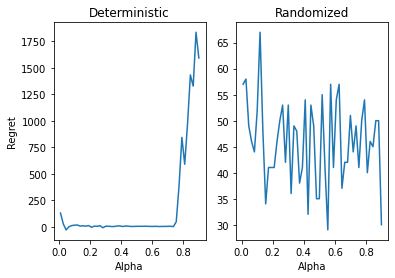

In [19]:
# number of experts
n = 100
# number of rounds played
T = 10000

list_of_correct_answers = random.choice([False, True], T)
probs = [random.random()**(1/2) for _ in range(n)]


alphas = np.linspace(0.01,0.9, 50)
regret_arr_det = np.empty(50)
regret_arr_rand = np.empty(50)


for i in range(len(alphas)):
    my_mistakes_det, expert_mistakes_det = WMA(n, T, alphas[i])
    regret_arr_det[i] = my_mistakes_det - np.min(expert_mistakes_det[:, -1])
    
    my_mistakes_rand, expert_mistakes_rand = WMA(n, T, alpha, randomized=True)
    regret_arr_rand[i] = my_mistakes_rand - np.min(expert_mistakes_rand[:, -1])
    
    
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('Deterministic')
ax2.set_title('Randomized')
ax1.set_xlabel("Alpha")
ax1.set_ylabel("Regret")
ax2.set_xlabel("Alpha")

ax1.plot(alphas, regret_arr_det)
ax2.plot(alphas, regret_arr_rand)

plt.show()

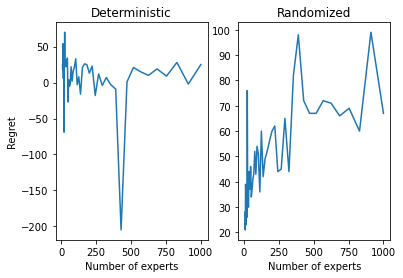

In [24]:

# number of rounds played
T = 10000
list_of_correct_answers = random.choice([False, True], T)

ns = np.logspace(1, 3)
alpha = 0.1

regret_arr_det = np.empty(50)
regret_arr_rand = np.empty(50)

for i in range(len(ns)):

    n = ns[i].astype(int)
    probs = [random.random()**(1/2) for _ in range(n)]
    
    my_mistakes_det, expert_mistakes_det = WMA(n, T, alpha)
    regret_arr_det[i] = my_mistakes_det - np.min(expert_mistakes_det[:, -1])
                                            
    my_mistakes_rand, expert_mistakes_rand = WMA(n, T, alpha, randomized=True)
    regret_arr_rand[i] = my_mistakes_rand - np.min(expert_mistakes_rand[:, -1])


fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('Deterministic')
ax2.set_title('Randomized')
ax1.set_xlabel("Number of experts")
ax1.set_ylabel("Regret")
ax2.set_xlabel("Number of experts")

ax1.plot(ns, regret_arr_det)
ax2.plot(ns, regret_arr_rand)

plt.show()

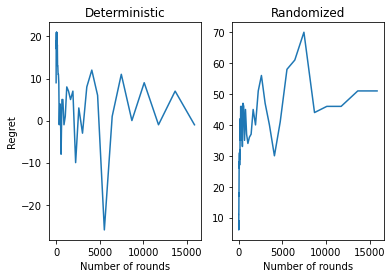

In [30]:
# number of rounds played
n = 100
probs = [random.random()**(1/2) for _ in range(n)]

ts = np.logspace(1, 4.2)
alpha = 0.1

regret_arr_det = np.empty(50)
regret_arr_rand = np.empty(50)

for i in range(len(ns)):

    T = ts[i].astype(int)
    list_of_correct_answers = random.choice([False, True], T)
    
    my_mistakes_det, expert_mistakes_det = WMA(n, T, alpha)
    regret_arr_det[i] = my_mistakes_det - np.min(expert_mistakes_det[:, -1])
                                            
    my_mistakes_rand, expert_mistakes_rand = WMA(n, T, alpha, randomized=True)
    regret_arr_rand[i] = my_mistakes_rand - np.min(expert_mistakes_rand[:, -1])


fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('Deterministic')
ax2.set_title('Randomized')
ax1.set_xlabel("Number of rounds")
ax1.set_ylabel("Regret")
ax2.set_xlabel("Number of rounds")

ax1.plot(ts, regret_arr_det)
ax2.plot(ts, regret_arr_rand)

plt.show()

In [42]:
def get_expert_answers_not_completely_random(true_answer, weights):
    
    best_weights = np.where(weights == np.max(weights))[0]
    expert_answers = np.zeros(len(probs), dtype=bool) + true_answer
    
    rnd = random.random(best_weights.shape[0])
    
    experts_that_lie = (rnd <= probs[best_weights])
    expert_answers[best_weights[experts_that_lie]] = np.logical_not(true_answer)

    
    return expert_answers

In [43]:
alpha = 0.1
my_mistakes_det, expert_mistakes_det = WMA(n, T, alpha, random_experts=False)
my_mistakes_rand, expert_mistakes_rand = WMA(n, T, alpha, randomized=True, random_experts=False)

print(f'I made {my_mistakes_det} mistakes.')
print(f'Best expert had {np.min(expert_mistakes_det[:, -1])} mistakes')

print(f'I made {my_mistakes_rand} mistakes.')
print(f'Best expert had {np.min(expert_mistakes_rand[:, -1])} mistakes')

I made 1218 mistakes.
Best expert had 1217.0 mistakes
I made 1208 mistakes.
Best expert had 1199.0 mistakes


In [73]:
def get_expert_answers_MWA(n):
    """
    Each expert random choose a number between -0.1 and 0.1. The lower the better.
    """
    return np.random.uniform(-0.1, 0.1, n)

In [81]:
def form_your_answer_MWA(expert_answers, weights):
    
    prob = weights / np.sum(weights)
    your_answer = np.random.choice(expert_answers, size=1, p=prob)        
    return your_answer

In [82]:
def MWA(n, T, alpha=0.1):
    """Run the multiplicative weights algorithm with `n` experts for `T` timesteps"""
    
    # initialize weights
    weights = np.ones(n)
    your_loss = 0
    experts_loss = np.zeros((n,T+1))
    
    answers = get_expert_answers_MWA(n)

    for t in range(T):       
        expert_answers = answers
        your_answer = form_your_answer_MWA(expert_answers, weights)
        your_loss += your_answer
        experts_loss[:, t] = expert_answers
            
        weights = np.multiply(1 - alpha * expert_answers, weights)
        
                
                
    return your_loss, experts_loss    



In [78]:
my_loss, experts_loss = MWA(n, T)
print(f'My loss: {my_loss}.')
print(f'Best expert loss {np.min(np.sum(experts_loss, axis=1))}')


My loss: [-1533.21784233].
Best expert loss -1573.9906018422926


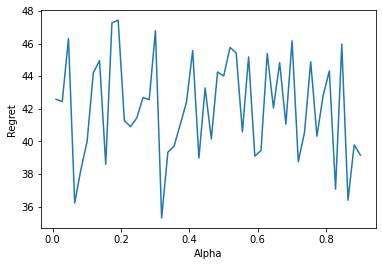

In [80]:
# number of experts
n = 100
# number of rounds played
T = 10000

alphas = np.linspace(0.01,0.9, 50)
regret_arr = np.empty(50)


for i in range(len(alphas)):
    my_loss, experts_loss = MWA(n, T)
    regret_arr[i] = my_loss - np.min(np.sum(experts_loss, axis=1))
    
    
    
plt.figure()
plt.xlabel("Alpha")
plt.ylabel("Regret")
plt.plot(alphas, regret_arr)

plt.show()

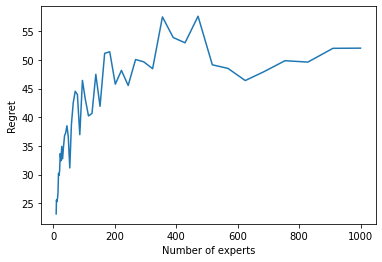

In [85]:
alpha = 0.1
T = 10000
ns = np.logspace(1, 3)

regret_arr = np.empty(50)


for i in range(len(alphas)):
    n = ns[i].astype(int)
    my_loss, experts_loss = MWA(n, T)
    regret_arr[i] = my_loss - np.min(np.sum(experts_loss, axis=1))
    
    
    
plt.figure()
plt.xlabel("Number of experts")
plt.ylabel("Regret")
plt.plot(ns, regret_arr)

plt.show()

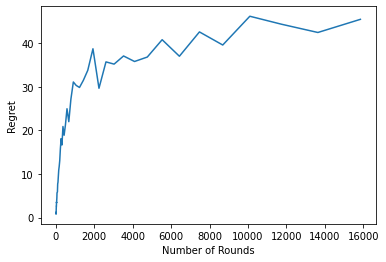

In [86]:
alpha = 0.1
n = 100
ts = np.logspace(1, 4.2)

regret_arr = np.empty(50)


for i in range(len(alphas)):
    T = ts[i].astype(int)
    my_loss, experts_loss = MWA(n, T)
    regret_arr[i] = my_loss - np.min(np.sum(experts_loss, axis=1))
    
    
    
plt.figure()
plt.xlabel("Number of Rounds")
plt.ylabel("Regret")
plt.plot(ts, regret_arr)

plt.show()